In [1]:
import strongholds
import strongholds.graphing as mplt

import numpy as np

import ipywidgets

fixed_rng = np.random.default_rng(0)

Let us return to the example of a single world with a player located at (3000, -300).

In [2]:
player = strongholds.rectpoint(3000, -300)

all_strongholds = strongholds.generate_all(rng=fixed_rng)

target = strongholds.closest_stronghold(player, all_strongholds)
print("Closest stronghold to (3000, -300):", strongholds.math.to_xz(target))

Closest stronghold to (3000, -300): [2168.  344.]


If this player throws an Eye of Ender at that location, it will fly out at the following polar angle:

In [3]:
throw_angle = strongholds.math.angle(target - player)
throw_angle

2.4828835918707717

Digression: the polar angle in radians is that of the $xz$ plane and is measured relative to the $x$ axis. However, the angle given by the debug screen in-game is given in degrees, and is measured in the cardinal plane relative to the north direction (as the $+z$ direction corresponds to *south*, not north).

In the example above, the throw angle given by the F3 screen would read:

In [4]:
strongholds.to_yrot(throw_angle)

127.74124916352238

The Eye of Ender points *directly* to the (8, 8) of the stronghold that it generates from; this was changed to point towards (0, 0) in 1.19. As such, not only are there a finite number of grid points that a stronghold can generate at, but there is an even smaller set of these points that fall along the line of the Eye of Ender Throw.

There is, of course, a catch - there is always a bit of uncertainty in the measurement of the Eye of Ender throw. As such, if you measure the angle of the throw, the possible strongholds actually lie in a cone emanating out from the player, with its angular width being equal to twice this measurement uncertainty. As such, minimizing the measurement uncertainty (e.g. by [calibrating your angle with a boat](https://github.com/Ninjabrain1/Ninjabrain-Bot/wiki/Boat-measurements)) is essential for finding the stronghold, especially in speedrunning contexts where the goal is to find it in one throw.

Most of the time, only the nearest few rings will matter, so for right now we work with the first two rings. If our error is $0.01$ radians, we end up with a total of 1866 possible stronghold locations:

In [5]:
dphi = 1e-2

grid = strongholds.generation_grid(range(2))
possible_targets = strongholds.points_in_cone(player, grid, throw_angle, dphi)

display(
    strongholds.math.to_xz(possible_targets),
    len(possible_targets)
)

array([[ 2808.,  -152.],
       [ 2792.,  -136.],
       [ 2744.,  -104.],
       ...,
       [-3432.,  4760.],
       [-3416.,  4760.],
       [-3432.,  4776.]])

1866

Of course, many of those locations will be less likely than the others; computations of those probabilities will come later. For now, we can make an interactive plot of this below:

In [6]:
# computes the cone lines
t = np.linspace(0, 30000)
ray_0 = player + strongholds.math.cis(throw_angle) * t
ray_p = player + strongholds.math.cis(throw_angle + dphi) * t
ray_m = player + strongholds.math.cis(throw_angle - dphi) * t

interactive(children=(FloatLogSlider(value=0.01, description='Angle Error', max=-1.0, min=-6.0), FloatSlider(v…

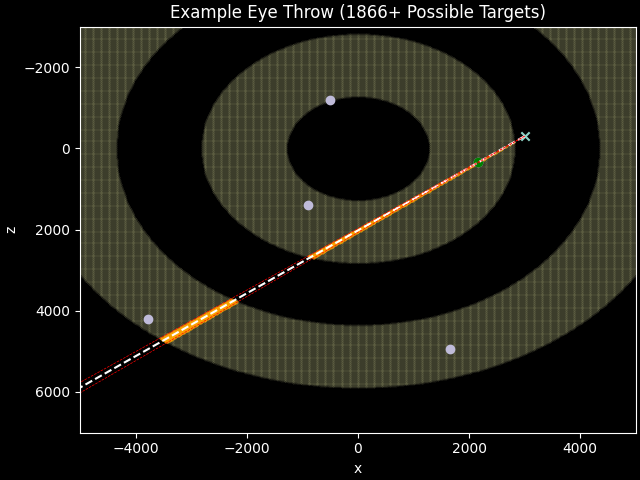

In [7]:
%matplotlib widget
fig, ax = mplt.xz_subplots()
ax.set_title(f"Example Eye Throw ({len(possible_targets)}+ Possible Targets)")
#fig.subplots_adjust(bottom=0.25)

# graphs the player and their "throw cone"
player_point = ax.scatter(player.real, player.imag, marker="x")
line_0, = ax.plot(ray_0.real, ray_0.imag, ls="--", color="white")
line_p, = ax.plot(ray_p.real, ray_p.imag, ls="--", lw=0.5, color="red")
line_m, = ax.plot(ray_m.real, ray_m.imag, ls="--", lw=0.5, color="red")

# graphs all of the strongholds and the grid points they can lie on
ax.scatter(grid.real, grid.imag, s=1e-3)
ax.scatter(all_strongholds.real, all_strongholds.imag)

# gives unique colors to the possible targets and the actual target
possible_targets_scatter = ax.scatter(possible_targets.real, possible_targets.imag, 1e-1, color="orange")
target_scatter = ax.scatter(target.real, target.imag, color="green")

dphi_slider = ipywidgets.FloatLogSlider(value=1e-2, base=10, min=-6,
                                        max=-1, step=0.1,
                                        description="Angle Error")
x_slider = ipywidgets.FloatSlider(value=3000, min=-2000, max=3000)
z_slider = ipywidgets.FloatSlider(value=-300, min=-2000, max=2000)

@ipywidgets.interact(dphi=dphi_slider, x=x_slider, z=z_slider)
def update(dphi: float, x: float, z: float) -> None:
    # update the player location and resulting data
    player = strongholds.rectpoint(x, z)

    target = strongholds.closest_stronghold(player, all_strongholds)
    throw_angle = strongholds.math.angle(target - player)
    possible_targets = strongholds.points_in_cone(player, grid, throw_angle, dphi)

    ray_0 = player + strongholds.math.cis(throw_angle) * t
    ray_p = player + strongholds.math.cis(throw_angle + dphi) * t
    ray_m = player + strongholds.math.cis(throw_angle - dphi) * t

    # update the plots    
    player_point.set_offsets(strongholds.math.to_xz(player))

    target_scatter.set_offsets(strongholds.math.to_xz(target))

    line_0.set_data(ray_0.real, ray_0.imag)
    line_p.set_data(ray_p.real, ray_p.imag)
    line_m.set_data(ray_m.real, ray_m.imag)

    possible_targets_scatter.set_offsets(strongholds.math.to_xz(possible_targets))

    ax.set_title(f"Example Eye Throw ({len(possible_targets)}+ Possible Targets)")

_ = ax.set_xlim(-5000, 5000)
_ = ax.set_ylim(7000, -3000)

Messing with the slider gives upwards of 20,000 possible stronghold locations when the error is around $10^{-2}$, while errors below $10^{-4}$ yield less than 20 of them. To get one possible stronghold (the correct one), the error needs to be around $10^{-4.8}$ or below.